In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
sns.set_theme()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Load Data

In [8]:
df = pd.read_parquet('../data/clustered_MSISDN.parquet')

### EDA on clusters

In [2]:
# Average package price per MSISDN in each cluster
plt.figure(figsize=(10, 5))
sns.boxplot(df, x='label', y='IPK_PRICE_IN_VAT', hue='label', palette=sns.color_palette(n_colors=9), legend=False)
plt.title('Average package price in each segment', fontsize=15)
plt.xlabel('Segment')
plt.ylabel('Package Price (THB)')
plt.ylim((0, 250));

In [9]:
# Revenue per MSISDN in each cluster
df['ALL_TRX'] = df['SYS_TRX'] + df['DIGITAL_TRX'] + df['KIOSK_POS_TRX'] + df['LEGACY_TRX'] + df['AGENT_TRX']
df['REVENUE'] = df['ALL_TRX'] * df['IPK_PRICE_IN_VAT']

In [3]:
# Average revenue per customer
plt.figure(figsize=(10, 5))
sns.boxplot(df, x='label', y='REVENUE', hue='label', palette=sns.color_palette(n_colors=9), legend=False)
plt.title('Average revenue per customer in each segment', fontsize=15)
plt.xlabel('Segment')
plt.ylabel('Revenue (THB)')
plt.ylim((0, 1400));

In [4]:
# Package price vs trx numbers
colors = sns.color_palette(n_colors=9)
colors[4], colors[8] = colors[8], colors[4]

plt.figure(figsize=(10, 5))
sns.scatterplot(df, x='ALL_TRX', y='IPK_PRICE_IN_VAT', hue='label', palette=colors, s=20)
# sns.scatterplot(df, x='ALL_TRX', y='IPK_PRICE_IN_VAT', hue='label', palette=sns.color_palette('coolwarm', as_cmap=True), s=20, alpha=0.5)
plt.title('Average package price vs number of transactions', fontsize=15)
plt.xlabel('Transactions')
plt.ylabel('Avg package price (THB)')
plt.legend(title='Segment', markerscale=3)
plt.ylim((-10, 2000))
plt.xlim((0, 125));

In [5]:
# Package price vs trx numbers (cluster 0 vs 4)
# df['label'] = df['label'].map(lambda x: 'Other' if not x in [0, 4] else x)

# plt.figure(figsize=(10, 5))
# sns.scatterplot(df[df['label'].isin([0, 4])], x='ALL_TRX', y='IPK_PRICE_IN_VAT', hue='label', palette=[colors[0], colors[4]], s=20)
# # sns.scatterplot(plot_df, x='ALL_TRX', y='IPK_PRICE_IN_VAT', hue='label', palette=sns.color_palette('coolwarm', as_cmap=True), s=20, alpha=0.5)
# plt.title('Average package price vs number of transactions', fontsize=15)
# plt.xlabel('Transactions')
# plt.ylabel('Avg package price (THB)')
# plt.legend(title='Segment', markerscale=3)
# plt.ylim((-10, 2000))
# plt.xlim((0, 125));

In [6]:
# Revenue for whole cluster and MSISDN count
plt.figure(figsize=(10, 10))

plot_df = df[['label', 'REVENUE']].groupby('label').sum()
plt.subplot(2, 1, 1)
ax = sns.barplot(plot_df, y='REVENUE', x='label', palette=colors, hue='label', legend=False)
plt.title('Sum revenue of each segment vs number of customers', fontsize=15)
plt.xlabel(None)
plt.ylabel('Revenue (THB)')

plot_df = df['label'].value_counts()
plt.subplot(2, 1, 2)
ax = sns.barplot(x=plot_df.index, y=plot_df.values, palette=colors, hue=plot_df.index, legend=False)
plt.xlabel('Segment')
plt.ylabel('Number of customers');

In [7]:
# Net speed and quota for each cluster
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(15, 15))

cluster_label = 0
for i in range(3):
    for j in range(3):
        sns.scatterplot(df[df['label'] == cluster_label], x='NORMAL_NET_QUOTA', y='NORMAL_MAX_NET_SPEED', ax=axes[i, j], color=sns.color_palette(n_colors=9)[cluster_label]);
        axes[i, j].set_ylim(0, 1e6)
        axes[i, j].set_xlim(0, 2e6)
        cluster_label += 1

In [8]:
# Channel used by each cluster
plot_df = pd.melt(df[['label', 'SYS_TRX', 'DIGITAL_TRX', 'KIOSK_POS_TRX', 'LEGACY_TRX', 'AGENT_TRX']], id_vars='label', var_name='channel', value_name='trx')
plot_df = plot_df.groupby(['label', 'channel'], as_index=False).sum()
sns.barplot(plot_df, x='label', y='trx', hue='channel')
plt.title('Channel transactions in each segment', fontsize=15)
legend = plt.legend()
legend.get_texts()[0].set_text('Agent')
legend.get_texts()[1].set_text('Digital')
legend.get_texts()[2].set_text('Kiosk/POS')
legend.get_texts()[3].set_text('Legacy (USSD/SMS)')
legend.get_texts()[4].set_text('Recurring')
plt.xlabel('Segment')
plt.ylabel('Transactions');

In [9]:
# OC vs RC used by each cluster
plot_df = pd.melt(df[['label', 'OC', 'RC']], id_vars='label', var_name='type', value_name='trx')
plot_df = plot_df.groupby(['label', 'type'], as_index=False).sum()
plt.figure(figsize=(10, 5))
sns.barplot(plot_df, x='label', y='trx', hue='type')
plt.title('Charging types preferred by each segment', fontsize=15)
legend = plt.legend()
legend.get_texts()[0].set_text('One-time package')
legend.get_texts()[1].set_text('Recurring package')
plt.xlabel('Segment')
plt.ylabel('Charging type count');

In [10]:
# Package type bought by each cluster
plot_df = pd.melt(df[['label', 'NORMAL_NET_Limit',
    'NORMAL_NET_Unlimit', 'LIFESTYLE_Unlimit', 'SOCIAL_Limit',
    'SOCIAL_Unlimit', 'STREAMING_Limit', 'STREAMING_Unlimit',
    'WORK_OR_EDU_Unlimit']], id_vars='label', var_name='type', value_name='trx')
plot_df = plot_df.groupby(['label', 'type'], as_index=False).sum()
plt.figure(figsize=(10, 5))
sns.barplot(plot_df, x='label', y='trx', hue='type')
plt.title('Package types preferred by each segment', fontsize=15)
plt.xlabel('Segment')
plt.ylabel('Package type count');

In [11]:
# Package type bought by each cluster
plot_df = df[['label', 'IPK_VALIDITY_D']].groupby('label', as_index=False).mean()
plt.figure(figsize=(10, 5))
sns.barplot(plot_df, x='label', y='IPK_VALIDITY_D', palette=colors, hue='label', legend=False)
plt.title('Average package duration bought by each segment', fontsize=15)
plt.xlabel('Segment')
plt.ylabel('Average package duration');

### Visualize using PCA

#### Mixed PCA

In [13]:
# Apply PCA for visualization
pca = PCA(random_state=42)
ss = StandardScaler()
Z = pca.fit_transform(ss.fit_transform(df.drop(columns=['MSISDN', 'label'])))

In [17]:
# Check explained variance ratio
np.round(np.cumsum(pca.explained_variance_ratio_), 3)

array([0.174, 0.259, 0.322, 0.382, 0.438, 0.491, 0.543, 0.587, 0.627,
       0.663, 0.694, 0.725, 0.755, 0.785, 0.815, 0.841, 0.865, 0.886,
       0.903, 0.918, 0.93 , 0.942, 0.952, 0.961, 0.969, 0.977, 0.984,
       0.99 , 0.995, 0.999, 0.999, 1.   , 1.   , 1.   , 1.   , 1.   ])

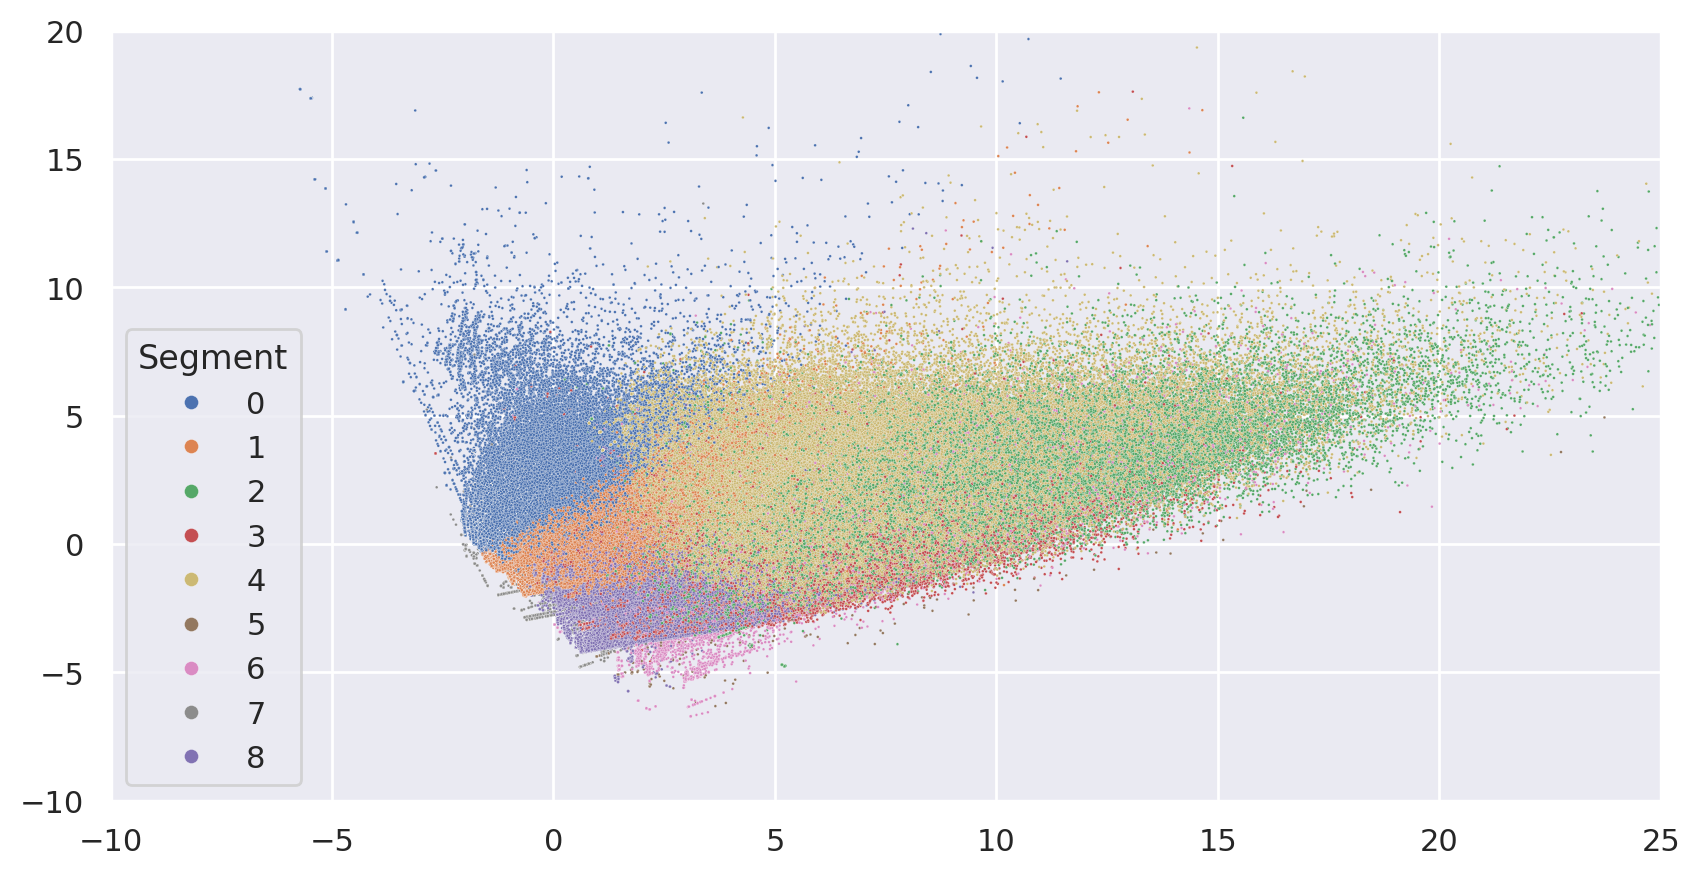

In [16]:
# visualize clusters separation
plt.figure(figsize=(10, 5))
# sns.scatterplot(x=Z[:, 0], y=Z[:, 1], hue=df['label'], palette=colors, s=1, alpha=0.5)
sns.scatterplot(x=Z[:, 0], y=Z[:, 1], hue=df['label'], palette=colors, s=1)
plt.legend(title='Segment', markerscale=5)
plt.ylim(-10, 20)
plt.xlim(-10, 25);

### Visualize using t-SNE

In [6]:
X, _, y, _ = train_test_split(df.drop(columns=['MSISDN', 'label']), df['label'], stratify=df['label'], train_size=50000, random_state=42)

In [7]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

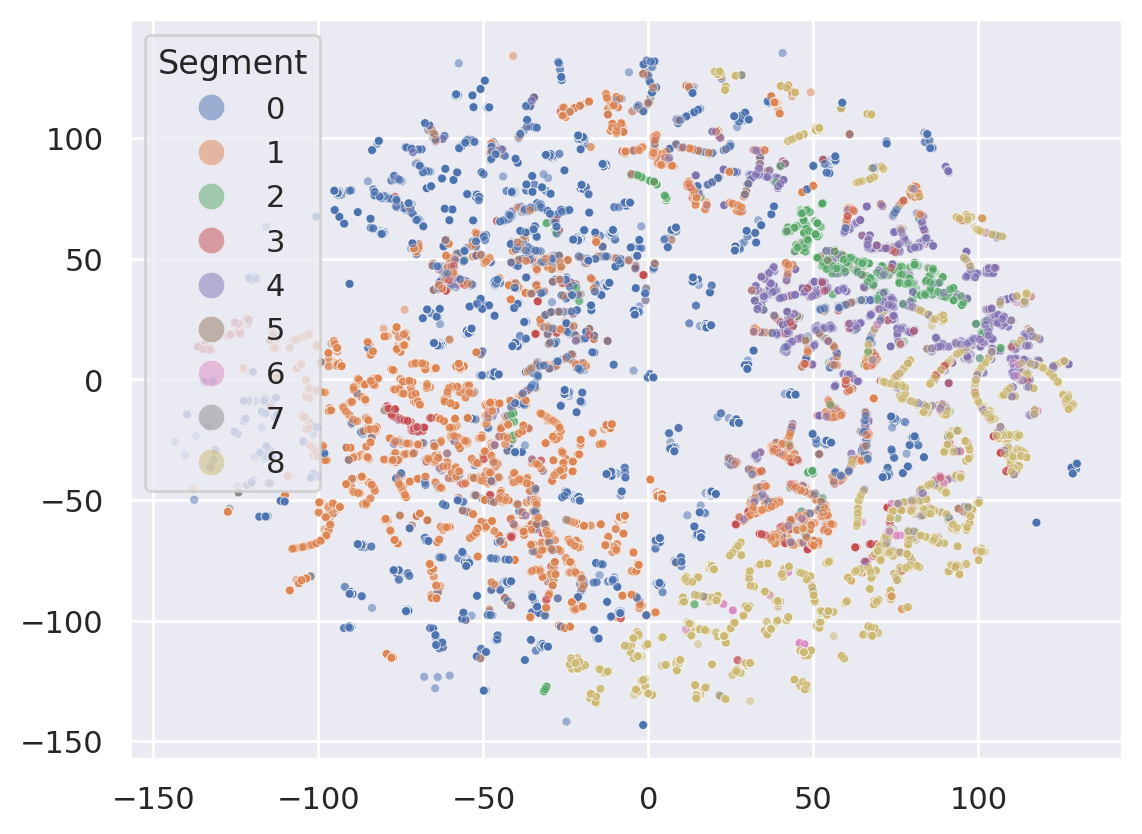

In [17]:
# visualize clusters separation
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette=sns.color_palette(n_colors=9), s=10, alpha=0.5)
plt.legend(title='Segment', markerscale=3);
# sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, alpha=0.5);